In [1]:
import Model
import tensorflow as tf
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

from extractMFCC import computeFeatures, computeFeatures1
from addNoise import addNoise
print(tf.__version__)

2.0.0-beta0


In [2]:
testWAVs = pd.read_csv('Dataset/testing_list.txt', sep=" ", header=None)[0].tolist()
valWAVs  = pd.read_csv('Dataset/validation_list.txt', sep=" ", header=None)[0].tolist()

for idx, item in enumerate(testWAVs):
    testWAVs[idx] = "Dataset/" + testWAVs[idx]

for idx, item in enumerate(valWAVs):
    valWAVs[idx] = "Dataset/" + valWAVs[idx]

In [3]:
DictCategs = {'nine' : 1, 'yes' : 2, 
                         'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 'stop' : 10, 'go' : 11,
                         'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 'six' : 18, 
                         'seven' : 19,  'eight' : 20, 'backward':0, 'bed':0, 'bird':0, 'cat':0, 'dog':0,
                         'follow':0, 'forward':0, 'happy':0, 'house':0, 'learn':0, 'marvin':0, 'sheila':0, 'tree':0,
                         'visual':0, 'wow':0}
nCategs = 21

In [4]:
allWAVs  = []
for root, dirs, files in os.walk('Dataset/'):
    if root != "Dataset/_background_noise_":
        allWAVs += [root+'/'+ f for f in files if f.endswith('.wav')]
trainWAVs = list( set(allWAVs)-set(valWAVs)-set(testWAVs) )

In [5]:
print(len(trainWAVs))
print(len(valWAVs))
print(len(testWAVs))

84843
9981
11005


In [6]:
def _getFileCategory(file, catDict):
    """
    Receives a file with name Dataset/<cat>/<filename> and returns an integer that is catDict[cat]
    """
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ,0)

In [7]:
#get categories
testWAVlabels = [_getFileCategory(f, DictCategs) for f in testWAVs]
valWAVlabels = [_getFileCategory(f, DictCategs) for f in valWAVs]
trainWAVlabels = [_getFileCategory(f, DictCategs) for f in trainWAVs]

In [13]:
print(len(trainWAVlabels))
print(len(valWAVlabels))
print(len(testWAVlabels))
#print(trainWAVs[:20])

84843
9981
11005


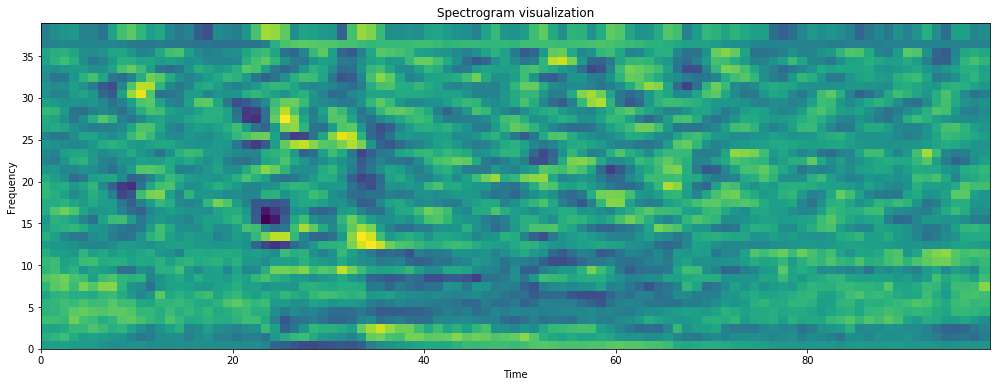

14


In [33]:
def load_and_preprocess_data(file_name):
    # Required by tensorflow (strings are passed as bytes)
    if type(file_name) is bytes:
        file_name = file_name.decode()
    # Load data
    feats = computeFeatures(file_name)
    # Normalize
    mean = np.mean(feats, axis = 0)
    stv = np.std(feats, axis = 0)
    diff = np.subtract(feats, mean)
    feats = np.divide(diff, stv)

    return feats.astype(np.float32)

# example:
feats = load_and_preprocess_data(trainWAVs[25])
feats = np.transpose(feats)

plt.figure(figsize=(17,6))
plt.pcolormesh(feats)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()
print(trainWAVlabels[25])

In [27]:
def create_dataset(file_names, labels, batch_size, shuffle, cache_file=None):
    
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    
    # Map the load_and_preprocess_data function
    py_func = lambda file_name, label: (tf.py_function(load_and_preprocess_data, [file_name], tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())
    
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)
    
    # Shuffle    
    if shuffle:
        dataset = dataset.shuffle(len(file_names))
        
    # Repeat the dataset indefinitely
    dataset = dataset.repeat()
    
    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, 1), label))
    
    # Batch
    dataset = dataset.batch(batch_size=batch_size)
    
    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)
    
    return dataset

In [28]:
batch_size = 32
train_dataset = create_dataset(trainWAVs, 
                               trainWAVlabels, 
                               batch_size=batch_size, 
                               shuffle=True,
                               cache_file='train_cache')

val_dataset = create_dataset(valWAVs, 
                             valWAVlabels,
                             batch_size=batch_size, 
                             shuffle=False,
                             cache_file='val_cache')

train_steps = int(np.ceil(len(trainWAVs)/batch_size))
val_steps = int(np.ceil(len(valWAVs)/batch_size))

In [30]:
model = Model.AttentionModel(21, 99, 39, use_GRU = True)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
num_epochs = 30
history = model.fit(train_dataset, epochs=num_epochs, steps_per_epoch=train_steps, validation_data=val_dataset, validation_steps=val_steps)

# Save the model
model.save('my_model.h5')

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['acc'], label='Train loss')
plt.plot(history.history['val_acc'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

W0620 22:18:57.198122 140278824412928 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0620 22:18:57.200473 140278816020224 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0620 22:18:57.225660 140278824412928 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0620 22:18:57.227292 140278816020224 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0620 22:18:57.231849 140278824412928 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


Epoch 1/30


InvalidArgumentError: TypeError: Can't convert 'tensorflow.python.framework.ops.EagerTensor' object to str implicitly
Traceback (most recent call last):

  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/script_ops.py", line 207, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/script_ops.py", line 109, in __call__
    ret = self._func(*args)

  File "<ipython-input-21-5bbc9037d551>", line 6, in load_and_preprocess_data
    feats = computeFeatures(file_name)

  File "/home/jupyter/HDA_Project/extractMFCC.py", line 15, in computeFeatures
    input_signal = read(wav_signal_name)

  File "/usr/local/lib/python3.5/site-packages/scipy/io/wavfile.py", line 233, in read
    fid = open(filename, 'rb')

TypeError: Can't convert 'tensorflow.python.framework.ops.EagerTensor' object to str implicitly


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNextSync]